# Exercise 04 ANN for Regression - Assignment

<span style="color:red">**The submission deadline of this assignment is February 4, 2025 at 23:59.**</span>

<span style="color:red">**In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained ANN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a regression model using ANN.

The problem to be solved is predicting the price of houses in California.

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a non-linear multi-layer ANN
- Train the ANN
- Save and load the trained model
- Make predictions and evaluation

### Pre-configure

- Import necessary libraries
- Specify the computation device for PyTorch

In [22]:
# import libraries
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [23]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Task 1. Build the data pipeline

<span style="color:red">**[TBC]**</span> You need to:
- Use `sklearn.datasets.fetch_california_housing()` to load California Housing dataset
- Pre-process the dataset
    - Scale numerical features with [min-max scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- Divide the dataset into the training and test set
- Create `TensorDataset` instances to store the dataset
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [24]:
# load diabetes dataset
feature, label = datasets.fetch_california_housing(
    return_X_y = True,
    as_frame = False, # get data as numpy array
)


In [25]:
feature

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [26]:
label

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [27]:
scaler = MinMaxScaler()
feature = scaler.fit_transform(feature)
# label = scaler.fit_transform(label.reshape(-1, 1))

In [28]:
# train test split
train_feature, test_feature, train_label, test_label = train_test_split(
    feature,
    label,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

In [29]:
# create the train and test dataset
# specify the type of data stored in the tensors to avoid incompatiblity
train_ds = TensorDataset(
    torch.tensor(train_feature, dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(test_feature, dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.float32)
)

In [30]:
# create the train and test data loaders ### PLAY WITH BATCH SIZE ###
batch_size = 64 # usually set to 2 to the nth power, recomendation to choose as big as possible
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)
# shuffle = True means the data is reshuffled at every epoch
# recommend to reshuffle training data
# don't reshuffle test data since test data will be fed to network only once
# we may also need to keep the order of test samples in the test set

In [31]:
# get a minibatch from the data loader and print shape of feature and label
for (X, y) in train_dl:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 8])
torch.Size([64])


## Task 2. Create a non-linear multi-layer ANN

<span style="color:red">**[TBC]**</span> You need to:
- Create a custom class to define the structure of the network
- Initialize the ANN by creating an instance of this class

In [32]:
# define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, n_labels)
        )
    def forward(self, X):
        return self.net(X)

In [33]:
# initialize the neural network
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)
# move the model to the computation device
model.to(device)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=4, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [34]:
# print network structure and learning parameters
print(f"Model structure:\n{model}\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

Model structure:
NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=4, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4, out_features=1, bias=True)
  )
)

Layer: net.0.weight | Size: torch.Size([128, 8])
Layer: net.0.bias | Size: torch.Size([128])
Layer: net.2.weight | Size: torch.Size([64, 128])
Layer: net.2.bias | Size: torch.Size([64])
Layer: net.4.weight | Size: torch.Size([32, 64])
Layer: net.4.bias | Size: torch.Size([32])
Layer: net.6.weight | Size: torch.Size([16, 32])
Layer: net.6.bias | Size: torch.Size([16])
Layer: net.8.weight | Size: torch.Size([4, 16])
Layer: net.8.bias | Size: torch.Size([4])
Layer: net.10.weight | Size: torch.Size([

## Task 3. Train the ANN

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
- Specify training hyper-parameters:
    - the loss function
    - the optimizer
    - the learning rate
    - the number of epoches to train
- Train the ANN
    - Adjust the training hyper-parameters if necessary to get a good result
- Plot the loss history of the training process

In [35]:
# define the training function
def train(dataloader, model, loss_fn, optimizer, epochs):
    batch_loss_history = [] # for recording the average loss of a batch
    epoch_loss_history = [] # for recording the average loss of an epoch
    model.train() # set the model in training mode
    for epoch in range(epochs): # iterate pre-defined number of epoches
        epoch_loss = 0.0 # initial epoch loss is set to zero
        for (X, y) in dataloader: # get a batch of training samples
            X, y = X.to(device), y.to(device) # move data to the computation device
            pred = model(X).squeeze() # make predictions, squeeze() reduce `pred` to 1D tensor
            batch_loss = loss_fn(pred, y) # compute the current batch loss
            batch_loss.backward() # compute gradients by backpropagation
            optimizer.step() # update learning parameters according to gradients
            optimizer.zero_grad() # reset the gradients to zero
            batch_loss_history.append(batch_loss.item()) # record current batch loss
            epoch_loss += batch_loss.item() # accumulate batch losses for compute epoch loss
        epoch_loss /= len(dataloader) # compute current epoch loss
        epoch_loss_history.append(epoch_loss) # record current epoch loss
        print(f"Epoch {epoch + 1}: train loss = {epoch_loss}") # print log
    return batch_loss_history, epoch_loss_history

In [36]:
# define the training hyper-parameters #### PLAY WITH THESE PARAMETERS ####
loss_fn = nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # you should use the name of your network for the first argument
epochs = 100

In [37]:
# train the neural network
batch_loss_history, epoch_loss_history = train(train_dl, model, loss_fn, optimizer, epochs)

Epoch 1: train loss = 1.5427637609232843
Epoch 2: train loss = 1.3251987600748518
Epoch 3: train loss = 1.318822146780723
Epoch 4: train loss = 1.2993794917005352
Epoch 5: train loss = 1.1461015195973152
Epoch 6: train loss = 0.6190642875380221
Epoch 7: train loss = 0.5440834897149981
Epoch 8: train loss = 0.5411786123187141
Epoch 9: train loss = 0.5286896852529155
Epoch 10: train loss = 0.5085717221408819
Epoch 11: train loss = 0.5053296806537999
Epoch 12: train loss = 0.4960572352319692
Epoch 13: train loss = 0.4939290304231433
Epoch 14: train loss = 0.491323041375232
Epoch 15: train loss = 0.49269242426462934
Epoch 16: train loss = 0.4820910343422299
Epoch 17: train loss = 0.48331662893822763
Epoch 18: train loss = 0.4847735909629712
Epoch 19: train loss = 0.48401443811908235
Epoch 20: train loss = 0.4817904465362034
Epoch 21: train loss = 0.4803964224009387
Epoch 22: train loss = 0.4800216130978238
Epoch 23: train loss = 0.47104284233224075
Epoch 24: train loss = 0.4744412599675423

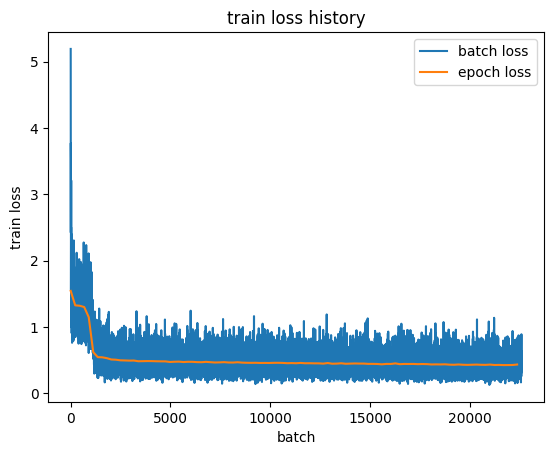

In [38]:
# plot the train loss history
plt.figure()
batch = np.arange(len(batch_loss_history))
epoch = np.arange(len(epoch_loss_history))
batches_per_epoch = (int(len(train_feature) / batch_size + 1))
plt.plot(batch, batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, epoch_loss_history, '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

## Task 4. Save and load the trained model

<span style="color:red">**[TBC]**</span> You need to:
- Save the trained model
    - <span style="color:red">**Don't forget to include the saved file in your submission.**</span>
- Re-create the neural network and load the saved model

In [42]:
# save model
file_name = 'trained_model.pth'
torch.save(model.state_dict(), file_name)
print('Saved PyTorch Model State to '+ file_name)

Saved PyTorch Model State to trained_model.pth


In [43]:
# load model
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)
model.load_state_dict(torch.load(file_name))

/var/folders/12/4xknp3ds50l867z9m2bm4xpr0000gn/T/ipykernel_5750/1337914836.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_name))


<All keys matched successfully>

In [44]:
# move model to the computation device
model.to(device)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=4, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4, out_features=1, bias=True)
  )
)

## Task 5. Make predictions and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
- Make predictions on the test dataset
- Evaluate the performance
    - Compute RMSE and print it
    - Compute $R^2$ score and print it
- Plot the predictions vs. target values

In [18]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_pred_list = [] # for recording batch predictions
    model.eval() # set the model in evaluation mode
    with torch.no_grad(): # disable automatic gradient computing
        loss = 0.0 # set initial test loss to zero
        for (X, y) in dataloader: # get a batch from test samples
            X, y = X.to(device), y.to(device) # move data to the computation device
            batch_pred = model(X).squeeze() # make predictions, squeeze() reduce `batch_pred` to 1D tensor
            batch_loss = loss_fn(batch_pred, y) # compute current batch loss
            loss += batch_loss.item() # accumulate batch losses for compute test loss
            batch_pred_list.append(batch_pred.cpu().numpy()) # move the batch predictions back to CPU and record
        loss /= len(dataloader) # compute test loss
        pred = np.concatenate(batch_pred_list) # reform the predictions as a numpy 1D array
        print(f"test loss = {loss}") # print log
    return pred, loss

In [39]:
# make prediction on test set and evaluate the performance
test_pred, test_loss = test(test_dl, model, loss_fn)

test loss = 0.43349067021891013


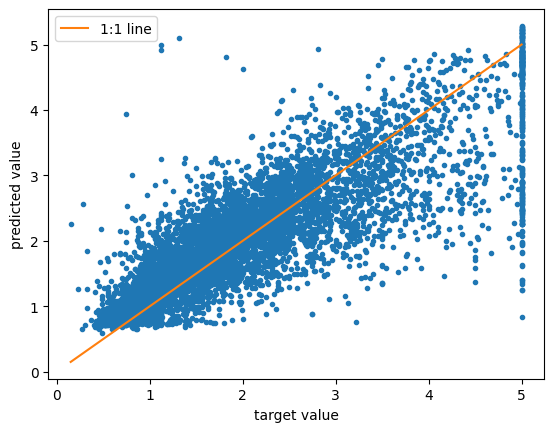

In [40]:
# plot the prediction results of the test dataset
plt.figure()
plt.plot(test_label, test_pred, '.')
plt.plot([min(test_label), max(test_label)], [min(test_label), max(test_label)], '-', label = '1:1 line')
plt.xlabel('target value')
plt.ylabel('predicted value')
plt.legend()
plt.show()

In [41]:
# calculate the evaluation metrics of the test dataset
print('RMSE =', root_mean_squared_error(test_label, test_pred))
print('R2 =', r2_score(test_label, test_pred))

RMSE = 0.6584661108542178
R2 = 0.6748408161280388


I tried by modifiyng many parameters and techniques to find the best combination, nevertheless I wasn't able to find something good, neither I understand that much what I was getting.